In [68]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from tqdm import tqdm
from mendeleev.fetch import fetch_table
from seaborn_fig2grid import SeabornFig2Grid
import matplotlib.gridspec as gridspec
import matplotlib


sns.set_style('whitegrid')
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
%matplotlib inline

sys.path.append(str(Path().resolve().parent))
op = Path("plots/proxy_loss/band_gap/")
op.mkdir(parents=True, exist_ok=True)

In [69]:
from dave import prepare_for_gfn

In [70]:
elements = fetch_table("elements")
elements = elements.set_index("atomic_number").drop(
    [c for c in elements.columns if c not in {"symbol", "atomic_number"}], axis=1
)


def to_formula(comp_tensor):
    mask = torch.nonzero(comp_tensor)
    counts = comp_tensor[mask].numpy().ravel()
    symbols = elements.loc[mask.numpy().ravel()].symbol
    return "".join([f"{s}{c}" for s, c in zip(symbols, counts)])

In [71]:
torch.set_grad_enabled(False)

print("Loading dave model")
model, loaders, scales = prepare_for_gfn(
    release="1.0.0",
    ckpt_path_dict={"mila": "/network/scratch/s/schmidtv/crystals-proxys/proxy-ckpts/"},
    rescale_outputs=True,
    # config_overrides={
    #     "src": "/home/minion/Documents/materials_dataset_v3/data/matbench_mp_gap",
    # },
)
print(list(model.state_dict().keys()))
print("Lattice parameters are standardized with:", scales["x"])
print("Energy prediction de-normalization stats:", scales["y"])

def denorm_y(y):
    return y * scales["y"]["std"] + scales["y"]["mean"]


def denorm_x(x):
    return x * scales["x"]["std"] + scales["x"]["mean"]

Loading dave model
  Making model...
    Loading Band Gap model.
  Loading proxy checkpoint...
Proxy ready.
['alphabet', 'phys_emb.phys_ref.group_mapping', 'phys_emb.phys_ref.period_mapping', 'phys_emb.phys_ref.properties_mapping', 'phys_emb.embeddings.z.weight', 'phys_emb.embeddings.properties.0.properties', 'phys_emb.embeddings.properties.1.weight', 'phys_emb.embeddings.properties.1.bias', 'phys_emb.embeddings.period.weight', 'phys_emb.embeddings.group.weight', 'phys_emb.phys_lin.weight', 'phys_emb.phys_lin.bias', 'phys_emb.final_proj.weight', 'phys_emb.final_proj.bias', 'sg_emb.weight', 'lat_emb_mlp.0.weight', 'lat_emb_mlp.0.bias', 'lat_emb_mlp.1.weight', 'lat_emb_mlp.1.bias', 'lat_emb_mlp.1.running_mean', 'lat_emb_mlp.1.running_var', 'lat_emb_mlp.1.num_batches_tracked', 'lat_emb_mlp.3.weight', 'lat_emb_mlp.3.bias', 'lat_emb_mlp.4.weight', 'lat_emb_mlp.4.bias', 'lat_emb_mlp.4.running_mean', 'lat_emb_mlp.4.running_var', 'lat_emb_mlp.4.num_batches_tracked', 'lat_emb_mlp.6.weight', 'la

/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [72]:
(comp, sg, lps), bg_normed = next(iter(loaders["train"]))
bg = denorm_y(bg_normed)
print(bg)

tensor([0.0000, 2.7831, 1.8691, 0.1153, 2.1544, 3.0742, 0.0000, 2.5510, 0.0000,
        0.0000, 2.8595, 2.3564, 1.6049, 2.1362, 0.0000, 0.0000, 6.3710, 0.0000,
        3.1003, 3.8110, 1.2884, 0.0000, 4.5570, 1.9142, 0.8240, 0.0000, 0.0000,
        0.0000, 0.0000, 4.7678, 5.2436, 0.0000, 0.0000, 0.0000, 2.1998, 1.1945,
        0.0000, 2.2542, 0.6320, 4.0245, 2.5052, 0.0460, 2.8012, 2.3621, 5.9591,
        0.0000, 2.6018, 0.0000, 0.7457, 3.1729, 1.4904, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 5.3600, 0.9272, 0.0000, 0.0000, 5.8675, 3.0110,
        0.0000, 0.0000, 1.3270, 1.9563, 1.5433, 1.4267, 0.0000, 2.4765, 0.0000,
        2.1662, 0.0000, 3.0444, 1.3684, 0.0000, 0.0000, 0.0000, 4.8340, 0.0000,
        5.0725, 0.5885, 0.0000, 0.0000, 0.1202, 4.3938, 0.0000, 0.2944, 0.0000,
        1.5011, 1.5373, 0.0000, 2.8714, 1.3648, 1.8839, 0.8540, 3.2880, 0.0000,
        0.0000, 0.1758, 0.0000, 0.2004, 1.4962, 2.8211, 0.0000, 2.1959, 1.1253,
        1.5842, 0.0000, 0.0000, 0.0000, 

In [73]:
df = []
for dataset in ["train", "val"]:
    for batch in tqdm(loaders[dataset], desc=dataset):
        x, bg_normed = batch
        comp, sg, lps = x
        pred_normed = model(x)
        pred = denorm_y(pred_normed)
        bg = denorm_y(bg_normed)
        lps = denorm_x(lps)

        for b in range(len(comp)):
            df.append({
                "comp": comp[b].numpy(),
                "formula": to_formula(comp[b]),
                "sg": sg[b].item(),
                "lps": lps[b].numpy(),
                "a": lps[b][0].item(),
                "b": lps[b][1].item(),
                "c": lps[b][2].item(),
                "alpha": lps[b][3].item(),
                "beta": lps[b][4].item(),
                "gamma": lps[b][5].item(),
                "bg_normed": bg_normed[b].item(),
                "bg": bg[b].item(),
                # "bg_normed": bg_normed[b].item(),
                # "bg": bg[b].item(),
                "pred_normed": pred_normed[b].item(),
                "pred": pred[b].item(),
                "dataset": dataset
            })
df = pd.DataFrame(df)
df["mae"] = df.apply(lambda row: np.abs(row["bg"] - row["pred"]), axis=1)
df["mae_normed"] = df.apply(lambda row: np.abs(row["bg_normed"] - row["pred_normed"]), axis=1)


train:   0%|          | 0/271 [00:00<?, ?it/s]

val:   0%|          | 0/97 [00:00<?, ?it/s]/home/mila/s/schmidtv/.conda/envs/crystal-proxy/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: 100%|██████████| 97/97 [00:23<00:00,  4.14it/s]


In [74]:
ref_df = pd.read_csv(
    "/network/scratch/s/schmidtv/crystals-proxys/data/materials_dataset_v3/data/matbench_mp_gap/val_data.csv"
)
element_cols = list(ref_df.columns[8:102])
ref_df["formula"] = ref_df[element_cols].apply(
    lambda row: to_formula(
        torch.tensor(np.concatenate([np.array([0]), row.values.astype(int)]))
    ),
    axis=1,
)
ref_df[["formula", "a", "b", "c", "alpha", "beta", "gamma", "Band Gap"]].head()

,formula,a,b,c,alpha,beta,gamma,Band Gap
0,O24P6Cr5Cu2,6.334047,8.020894,9.363562,106.03140,108.02200,101.52074,0.0000
1,O12F20Fe16,19.186357,6.185365,4.800125,90.00000,94.10042,90.00000,1.5869
2,Al76Co24U8,17.506714,12.006778,8.158563,90.00000,103.94732,90.00000,0.0000
3,O18Si4Ca6Ge2,7.203058,7.491543,8.092517,103.21514,95.43906,90.67810,4.3603
4,O4Zr2,3.643811,3.643811,5.314560,90.00000,90.00000,90.00000,3.8842


In [75]:
df[df.dataset == "val"][["formula", "a", "b", "c", "alpha", "beta", "gamma", "bg", "pred"]].head()

,formula,a,b,c,alpha,beta,gamma,bg,pred
51995,O24P6Cr5Cu2,6.334047,8.020894,9.363562,106.031403,108.022003,101.520737,0.0000,1.088195
51996,O12F20Fe16,19.186357,6.185365,4.800125,90.000000,94.100418,90.000000,1.5869,0.940365
51997,Al76Co24U8,17.506714,12.006778,8.158563,90.000000,103.947319,90.000000,0.0000,0.028728
51998,O18Si4Ca6Ge2,7.203058,7.491543,8.092517,103.215141,95.439056,90.678101,4.3603,4.216724
51999,O4Zr2,3.643811,3.643811,5.314560,90.000000,90.000000,90.000000,3.8842,3.330587


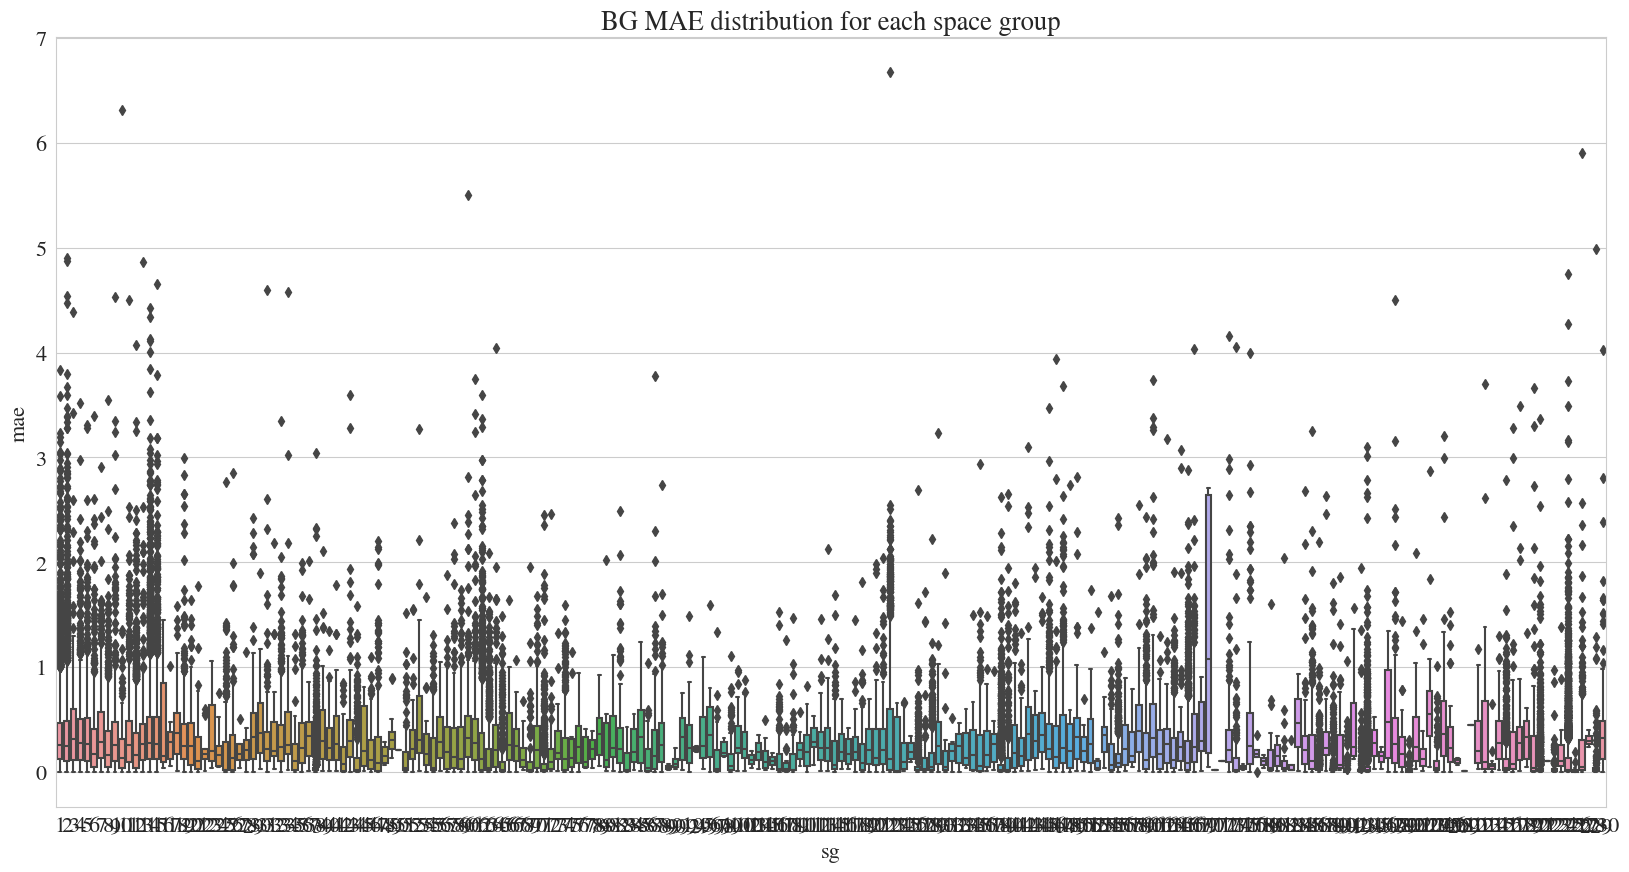

In [76]:
# boxplot of the MAE distribution for each space group
plt.figure(figsize=(20, 10))
sns.boxplot(x="sg", y="mae", data=df)
plt.title("BG MAE distribution for each space group")
plt.show()

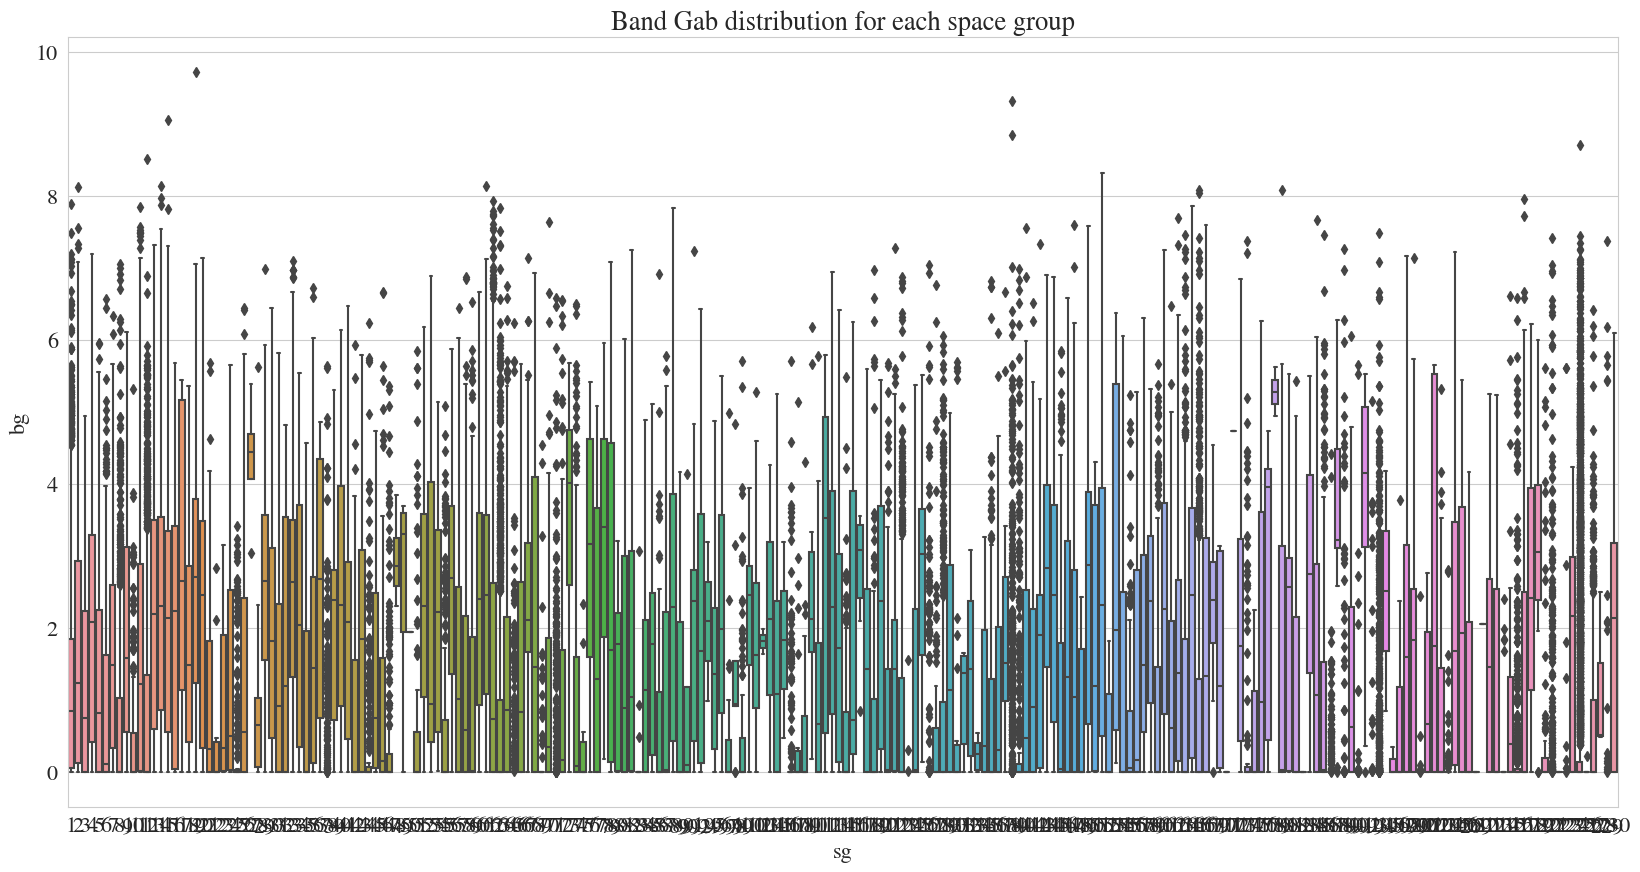

In [77]:
# boxplot of the MAE distribution for each space group
plt.figure(figsize=(20, 10))
sns.boxplot(x="sg", y="bg", data=df)
plt.title("Band Gab distribution for each space group")
plt.show()

In [78]:
stats = df[["sg", "mae", "bg"]].groupby("sg").describe()
stats

mae                                                              \
      count      mean       std       min       25%       50%       75%   
sg                                                                        
1    5677.0  0.369677  0.389546  0.000139  0.121638  0.260777  0.472280   
2    4003.0  0.376274  0.435542  0.000122  0.107144  0.252987  0.488452   
3     147.0  0.473323  0.593960  0.003163  0.119582  0.313235  0.600059   
4     968.0  0.387694  0.392438  0.000235  0.117355  0.276678  0.506034   
5     827.0  0.376275  0.394579  0.001800  0.103364  0.264910  0.520916   
..      ...       ...       ...       ...       ...       ...       ...   
226    28.0  0.020959  0.038567  0.001527  0.004686  0.007281  0.023293   
227   571.0  0.222237  0.402845  0.000231  0.016321  0.053465  0.307020   
228     3.0  0.313797  0.081046  0.244451  0.269249  0.294046  0.348469   
229   148.0  0.122868  0.455938  0.000978  0.014963  0.020430  0.037096   
230   179.0  0.426819  0.500243  0.004106  0.129514  0.322040  0.484700   

                   bg                                                 \
          max   count      mean       std     min       25%      50%   
sg                                                                     
1    3.835990  5677.0  1.211953  1.290914  0.0000  0.060500  0.84980   
2    4.900095  4003.0  1.687674  1.619145  0.0000  0.130600  1.24340   
3    4.387290   147.0  1.296310  1.377593  0.0000  0.000400  0.75590   
4    3.519863   968.0  2.133005  1.757747  0.0000  0.417975  2.08005   
5    3.307903   827.0  1.345464  1.475778  0.0000  0.000000  0.81810   
..        ...     ...       ...       ...     ...       ...      ...   
226  0.193030    28.0  0.007821  0.041387  0.0000  0.000000  0.00000   
227  5.902993   571.0  0.662522  1.182738  0.0000  0.000000  0.00000   
228  0.402893     3.0  1.172767  1.150016  0.4954  0.508850  0.52230   
229  4.990001   148.0  0.326622  1.237700  0.0000  0.000000  0.00000   
230  4.022838   179.0  1.879964  1.627367  0.0000  0.000000  2.13830   

                       
          75%     max  
sg                     
1    1.852800  7.8926  
2    2.934100  8.1320  
3    2.231850  4.9487  
4    3.298325  7.1994  
5    2.251050  5.9617  
..        ...     ...  
226  0.000000  0.2190  
227  0.996250  6.4233  
228  1.511450  2.5006  
229  0.000000  7.3713  
230  3.176750  6.1060  

[224 rows x 16 columns]

Text(0.5, 1.0, 'BG Space Group histogram')

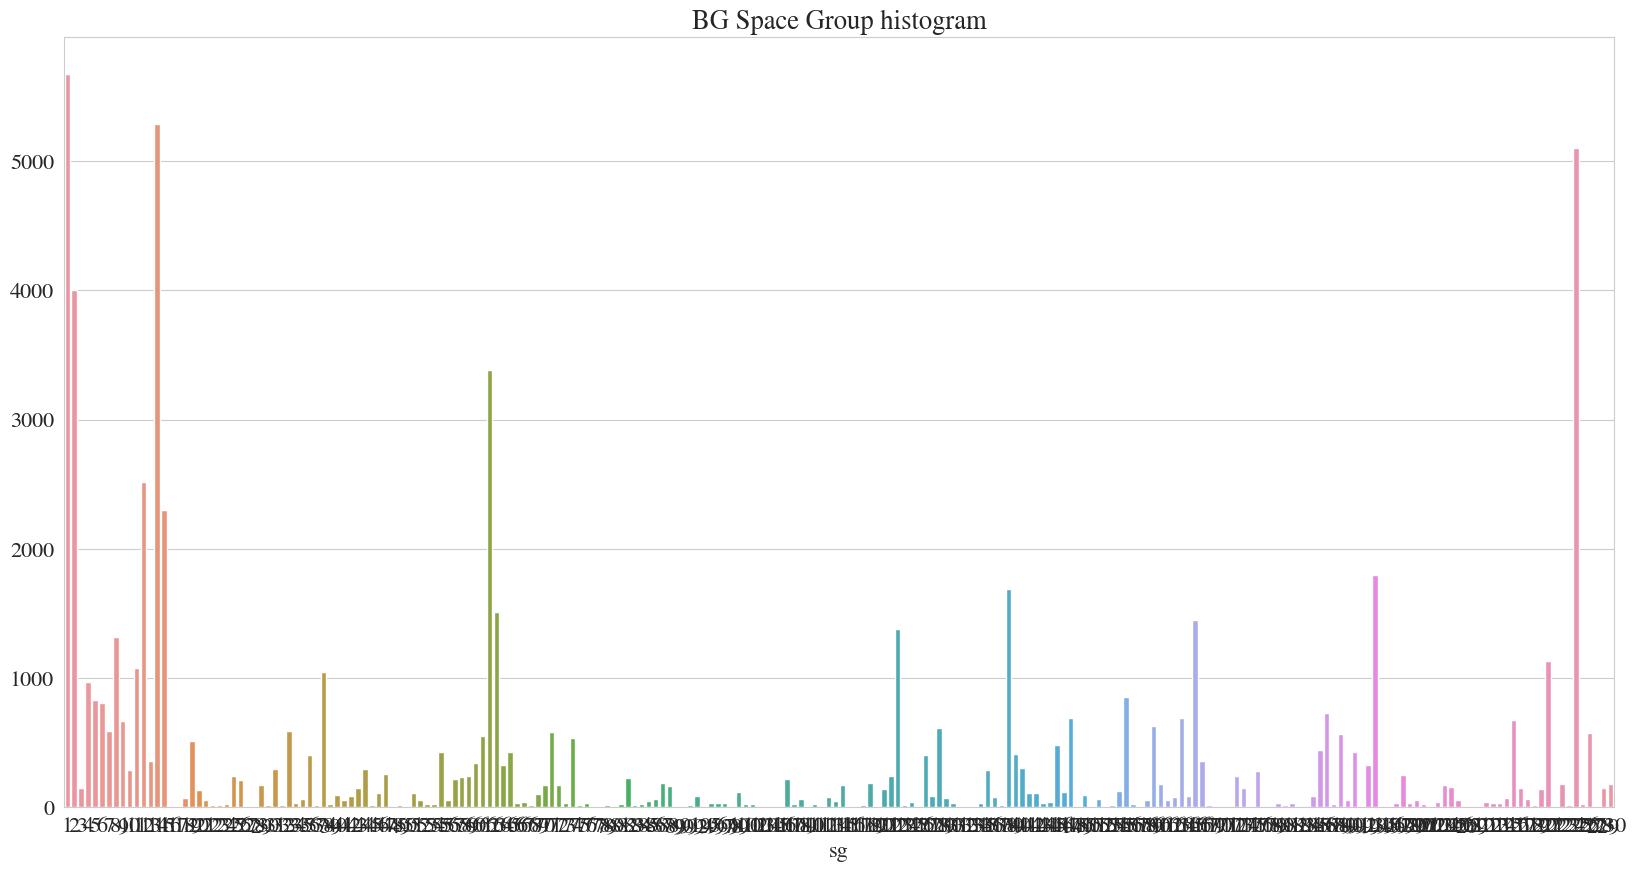

In [79]:
plt.figure(figsize=(20, 10))
sns.barplot(x=stats["mae"]["count"].index, y=stats["mae"]["count"].values)
plt.title("BG Space Group histogram")

In [80]:
# mask = stats["bg"]["75%"] > 0
# sg_pos = set(mask[mask].index)
# print("Selecting space groups with Band Gap 75% quantile > 0:", sg_pos, f"(n={mask.sum()})")

In [81]:
# # boxplot of the MAE distribution for each space group
# double_df = df.copy()
# double_df["sg"] = "all"
# double_df = pd.concat([df.copy(), double_df])

In [82]:
# plt.figure(figsize=(20, 10))
# sns.boxplot(x="sg", y="mae", data=double_df[double_df["sg"].isin(sg_pos | set(["all"]))], order=["all"] + sorted(sg_pos))
# plt.title("MAE distribution for each space group with Formation Energy 75% quantile > 0")
# plt.yscale("log")
# plt.show()

/tmp/ipykernel_26095/564784399.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim(0, 1200)


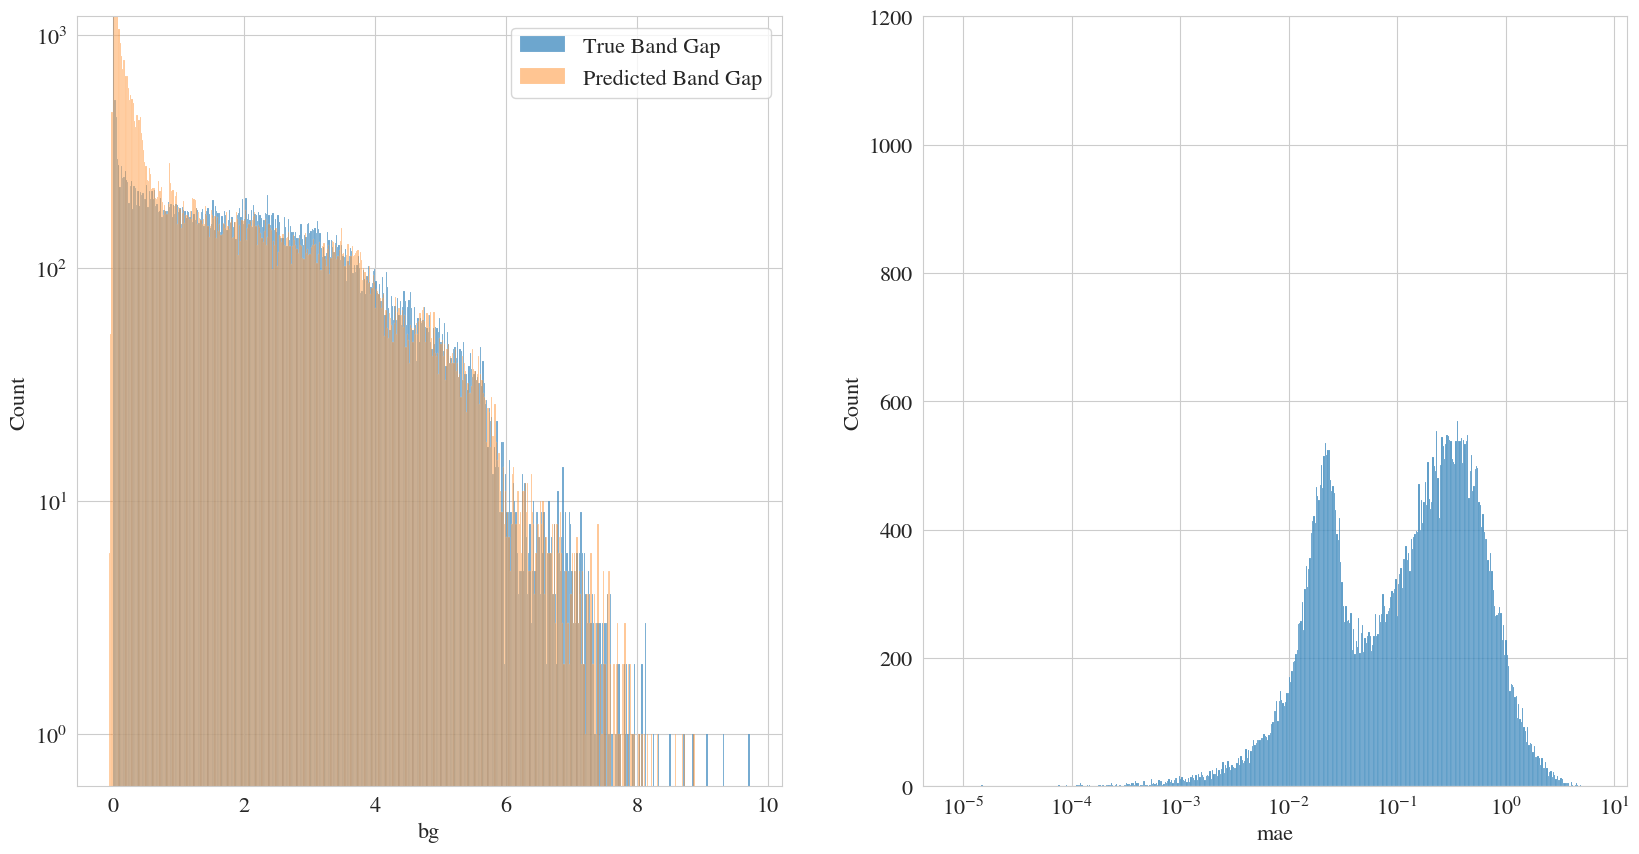

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(df["bg"], bins=500, log_scale=(False, True), ax=axs[0], label="True Band Gap", alpha=0.65)
sns.histplot(df["pred"], bins=500, log_scale=(False, True), ax=axs[0], label="Predicted Band Gap", alpha=0.45)
sns.histplot(df["mae"], label="MAE", bins=500, log_scale=(True, False), ax=axs[1])
axs[0].set_ylim(0, 1200)
axs[1].set_ylim(0, 1200)
axs[0].legend()

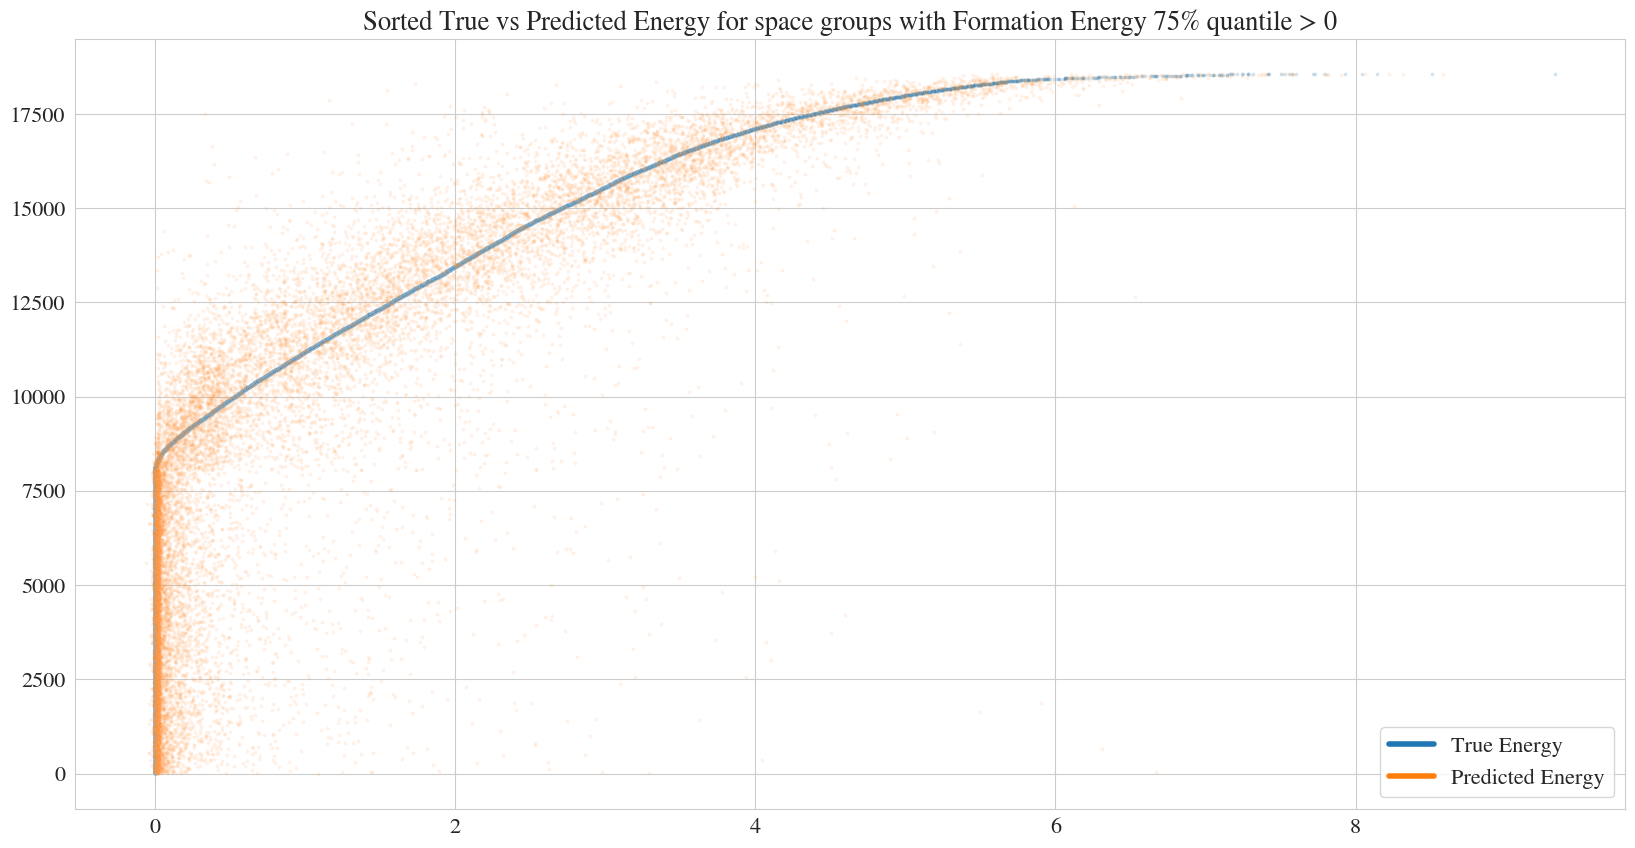

In [84]:
# sorted_df = df[(df.dataset == "val") & (df.sg.isin(sg_pos))]
sorted_df = df[(df.dataset == "val")]
sort_idx = np.argsort(sorted_df["bg"].values)
plt.figure(figsize=(20, 10))
sns.scatterplot(
    y=np.arange(len(sorted_df)),
    x=sorted_df["bg"].values[sort_idx],
    label="True Energy",
    alpha=0.2,
    s=7,
)
sns.scatterplot(
    y=np.arange(len(sorted_df)),
    x=sorted_df["pred"].values[sort_idx],
    label="Predicted Energy",
    alpha=0.1,
    s=7,
    color="C1",
)
# sns.scatterplot(
#     x=np.arange(len(sorted_df)),
#     y=sorted_df["mae"].values[sort_idx],
#     label="MAE",
#     alpha=0.3,
#     s=10,
#     color="C4",
# )
plt.title("Sorted True vs Predicted Energy for space groups with Formation Energy 75% quantile > 0")
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="C0", lw=4, label="True Energy"),
        plt.Line2D([0], [0], color="C1", lw=4, label="Predicted Energy"),
        # plt.Line2D([0], [0], color="C4", lw=4, label="MAE"),
    ],
)

/tmp/ipykernel_26095/3639848523.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdf.loc[:, "bg_bin"] = np.digitize(bdf["bg"], bg_bins) - 1


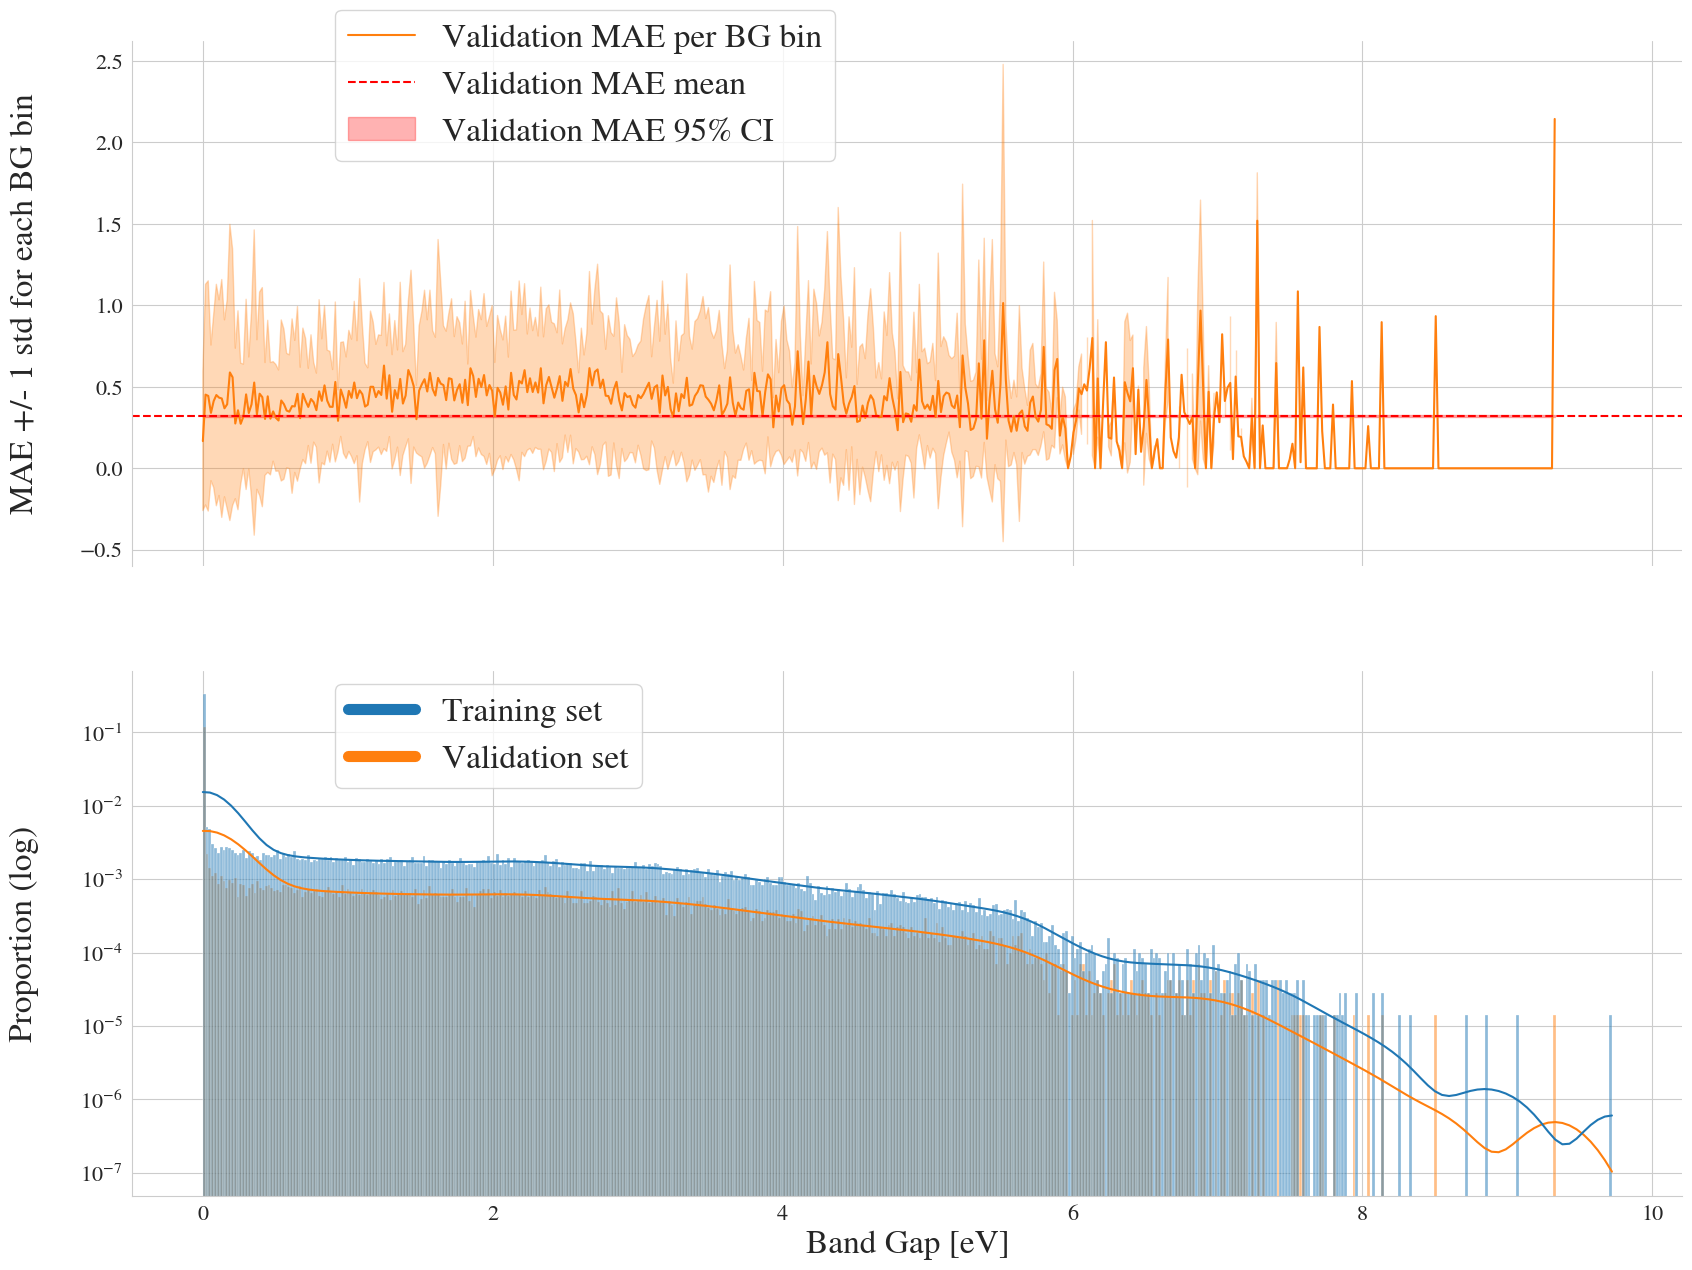

In [85]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
# bins bg and mae and then plot the distribution of mae for each bin
# with shaded area for 1 std around the mean
nbins = 500
bdf = df[(df.dataset == "val")]
fdf = df.copy()
fdf["Data set split"] = fdf["dataset"]

bg_bins = np.linspace(bdf["bg"].min(), bdf["bg"].max(), nbins + 1)
bdf.loc[:, "bg_bin"] = np.digitize(bdf["bg"], bg_bins) - 1

bg_bin_mae_mean = bdf.groupby("bg_bin")["mae"].mean()
tmp = np.zeros(nbins + 1)
tmp[bg_bin_mae_mean.index] = bg_bin_mae_mean.values
bg_bin_mae_mean = tmp

bg_bin_mae_std = bdf.groupby("bg_bin")["mae"].std()
tmp = np.zeros(nbins + 1)
tmp[bg_bin_mae_std.index] = bg_bin_mae_std.values
bg_bin_mae_std = tmp

bg_bin_count = bdf.groupby("bg_bin")["mae"].count()
tmp = np.zeros(nbins + 1)
tmp[bg_bin_count.index] = bg_bin_count.values
bg_bin_count = tmp
bg_bin_count = bg_bin_count / bg_bin_count.sum()


fig, ax = plt.subplots(2, 1, figsize=(20, 15), sharex=True,)
ax[0].plot(bg_bins, bg_bin_mae_mean, color="C1", label="Validation MAE per BG bin")
ax[0].fill_between(
    bg_bins,
    bg_bin_mae_mean - bg_bin_mae_std,
    bg_bin_mae_mean + bg_bin_mae_std,
    alpha=0.3,
    color="C1",
)
m, s = bdf["mae"].agg(["mean", "sem"])
ax[0].axhline(m, color="red", linestyle="--", label="Validation MAE mean")
ax[0].fill_between(
    bg_bins,
    m - 1.96 * s,
    m + 1.96 * s,
    alpha=0.3,
    color="red",
    label="Validation MAE 95% CI",
)
ax[0].legend(frameon=True, bbox_to_anchor=(0.12, 0.915), loc="center left", fontsize=24)

ax[0].set_ylabel("MAE +/- 1 std for each BG bin", fontsize=24)
sns.histplot(
    data=fdf,
    x="bg",
    hue="Data set split",
    bins=500,
    ax=ax[1],
    kde=True,
    stat="proportion",
    legend=True,
)
ax[1].set_yscale("log")
ax[1].set_xlabel("Band Gap [eV]", fontsize=24)
ax[1].set_ylabel("Proportion (log)", fontsize=24)
# manual legend for hist plot
ax[1].legend(
    handles=[
        plt.Line2D([0], [0], color="C0", lw=8, label="Training set"),
        plt.Line2D([0], [0], color="C1", lw=8, label="Validation set"),
    ],
    frameon=True,
    bbox_to_anchor=(0.12, 0.875), loc="center left",
    fontsize=24,
)
sns.despine(ax=ax[0], top=True, right=True, bottom=True, left=False)
sns.despine(ax=ax[1], top=True, right=True, bottom=False, left=False)
# plt.tight_layout()
# aligning ylabels to the right from both axs:
ax[0].yaxis.set_label_coords(-0.06, 0.5)
ax[1].yaxis.set_label_coords(-0.06, 0.5)

plt.savefig(op / "mae-dist.pdf")


In [86]:
print(bdf["mae"].mean())
print(bdf["mae"].std())
print(bdf[bdf["bg"] < 0]["mae"].mean())
print(bdf[bdf["bg"] < 0]["mae"].std())

0.321087493653187
0.46668490879622876
nan
nan


In [87]:
stats = bdf["mae"].agg(['mean', 'sem'])
print(stats)
print('-'*30)


stats['ci95_hi'] = stats['mean'] + 1.96* stats['sem']
stats['ci95_lo'] = stats['mean'] - 1.96* stats['sem']
print(stats)
print(f"{stats['mean']:.3f} +/- {stats['sem']:.3f}")

mean    0.321087
sem     0.003425
Name: mae, dtype: float64
------------------------------
mean       0.321087
sem        0.003425
ci95_hi    0.327800
ci95_lo    0.314375
Name: mae, dtype: float64
0.321 +/- 0.003


In [88]:
import matplotlib.gridspec as gridspec


def joint_plot(
    df,
    x,
    y,
    scale_kwarg={},
    labels={
        "mae": "MAE (eV)",
        "eform": "Formation Energy (eV)",
        "sg": "Space Group",
    },
    figsize=(10, 10),
):
    plt.figure(figsize=figsize)
    g = sns.JointGrid(data=df, x=x, y=y, marginal_ticks=True)
    g.ax_joint.set(**scale_kwarg)
    g.plot_joint(
        sns.histplot,
        discrete=(False, False),
        pmax=0.8,
        bins=500,
        color="#7371Fd",
    )
    g.plot_marginals(sns.histplot, element="step", color="#7371Fd")
    g.set_axis_labels(xlabel=labels[x], ylabel=labels[y])
    return g

In [89]:
# g0 = joint_plot(df, "sg", "mae", scale_kwarg={"yscale": "log"})
# g1 = joint_plot(df, "sg", "eform")
# g2 = joint_plot(df, "mae", "eform", scale_kwarg={"xscale": "log"})
# g3 = joint_plot(
#     df[df.sg.isin(sg_pos)],
#     "mae",
#     "eform",
#     scale_kwarg={"xscale": "log"},
#     labels={
#         "mae": "MAE (eV) for Space Groups with Formation Energy 75% quantile > 0",
#         "eform": "Formation Energy (eV)",
#         "sg": "Space Group",
#     },
# )

# fig = plt.figure(figsize=(16, 12))
# gs = gridspec.GridSpec(2, 2)

# mg0 = SeabornFig2Grid(g0, fig, gs[0])
# mg2 = SeabornFig2Grid(g1, fig, gs[2])

# mg1 = SeabornFig2Grid(g2, fig, gs[1])
# mg3 = SeabornFig2Grid(g3, fig, gs[3])


# gs.tight_layout(fig)
# # gs.update(top=0.7)

# plt.savefig("plots/proxy_loss/mae_eform_jointplot.png", dpi=300)
# plt.show()

<Figure size 500x500 with 0 Axes>

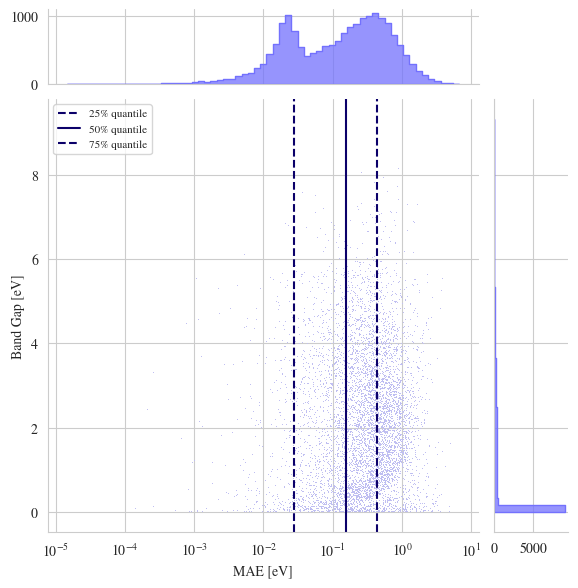

In [90]:

matplotlib.rcParams.update({'font.size': 10})


g = joint_plot(
    df[df.dataset == "val"],
    "mae",
    "bg",
    scale_kwarg={"xscale": "log"},
    labels={
        "mae": "MAE [eV]",
        "bg": "Band Gap [eV]",
        "sg": "Space Group",
    },
    figsize=(5,5)
)
# plot the 25 / 50 / 75 quantiles in mae error
_m = df[df.dataset == "val"]["mae"]
g.ax_joint.axvline(_m.quantile(0.25), color="#0B0069", linestyle="--", label="25% quantile")
g.ax_joint.axvline(_m.quantile(0.5), color="#0B0069", linestyle="-", label="50% quantile")
g.ax_joint.axvline(_m.quantile(0.75), color="#0B0069", linestyle="--", label="75% quantile")
g.ax_joint.legend(fontsize=8)
plt.savefig(op / "mae_bg_jointplot_val.pdf")
plt.savefig(op / "mae_bg_jointplot_val.png", dpi=250)


In [101]:
model.loaded_config

{'root': '/network/scratch/s/schmidtv/crystals-proxys/data/materials_dataset_v3/data/',
 'src': '$root/matbench_mp_gap/',
 'target': 'Band Gap',
 'scales': {'x': {'mean': tensor([ 7.3922,  8.0607, 11.4469, 90.2492, 94.2461, 95.2649]),
   'std': tensor([ 3.5157,  3.7326,  8.5179,  4.9310, 10.2904, 12.5099])},
  'y': {'mean': tensor(1.2144), 'std': tensor(1.5988)}},
 'comp_size': 94,
 'lat_size': 6,
 'alphabet': [1,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  89,
  90,
  91,
  92,
  93,
  94],
 'model': {'num_layers': 7,
  'hidden_channels': 1856,
  'sg_emb_size': 416,
  'lat_hidden

In [92]:
df.to_csv("plots/proxy_loss/proxy_loss.csv", index=False)

In [93]:
sorted({194, 228, 38, 71, 104, 139, 216, 187})

[38, 71, 104, 139, 187, 194, 216, 228]

In [94]:
model.loaded_config["model"]

{'num_layers': 7,
 'hidden_channels': 1856,
 'sg_emb_size': 416,
 'lat_hidden_channels': 448,
 'lat_num_layers': 3,
 'comp_num_layers': 1,
 'comp_hidden_channels': 416,
 'comp_phys_embeds': {'use': True,
  'z_emb_size': 384,
  'period_emb_size': 160,
  'group_emb_size': 160,
  'properties_proj_size': 384,
  'n_elements': 90}}

In [95]:
model.loaded_config["optim"]

{'batch_size': 192,
 'lr': 0.0018266226868788745,
 'epochs': 150,
 'es_patience': 11,
 'scheduler': {'name': 'ReduceLROnPlateau',
  'patience': 9,
  'step_size': 5000,
  'decay_factor': 0.5},
 'num_workers': 4}

In [96]:
model.loaded_config["run_dir"]

'/network/scratch/s/schmidtv/dave/runs/4068181-98'

In [98]:
mae = df[df.dataset == "val"]["mae"]
mae.describe()

count    18570.000000
mean         0.321087
std          0.466685
min          0.000015
25%          0.027438
50%          0.153524
75%          0.429645
max          6.672088
Name: mae, dtype: float64

In [99]:
1.96 * mae.sem()

0.006712338919941955

In [100]:
# https://github.com/marcoalopez/GrainSizeTools/blob/8c6f9e48cc0be3ff4080482739cf0e0f2dccb463/grain_size_tools/averages.py

from scipy.stats import bayes_mvs, gaussian_kde, iqr, t, norm

def critical_t(confidence, sample_size):
    """Returns the (two-tailed) critical value of t-distribution

    Parameters
    ----------
    confidence : float, scalar between 0 and 1
        the level of confidence. E.g. 0.95 -> 95%

    sample_size : scalar, int
        the sample size

    Assumptions
    -----------
    - the population is symmetric
    """

    # recalculate confidence for the two-tailed t-distribution
    confidence = confidence + ((1 - confidence) / 2)

    return t.ppf(confidence, sample_size)

def mCox_ci(data, ci=0.95):
    """ Returns the error margin for the arithmetic mean using the modified
    Cox method. This is a method optimized from lognormal populations. The
    method implemented below uses the Bessel corrected SD as it produces
    safer/robust results for small sample sizes

    Parameters
    ----------
    data : array_like
        the dataset

    ci : float, scalar between 0 and 1
        the confidence interval, default = 0.95

    Reference
    ---------
    Armstrong (1992) https://doi.org/10.1080/15298669291360003
    Lopez-Sanchez (2020) TODO

    Call
    ----
    calc_t

    Returns
    -------
    the lower and upper confidence intervals (tuple)
    the interval length (scalar)
    """

    n = len(data)
    t = critical_t(confidence=ci, sample_size=n)
    data = np.log(data)
    mean_log, std_log = np.mean(data), np.std(data, ddof=1)

    lower = np.exp(mean_log + 0.5
                   * std_log**2 - t
                   * (std_log / np.sqrt(n))
                   * np.sqrt(1 + (std_log**2 * n) / (2 * (n + 1))))
    upper = np.exp(mean_log + 0.5
                   * std_log**2 + t
                   * (std_log / np.sqrt(n))
                   * np.sqrt(1 + (std_log**2 * n) / (2 * (n + 1))))
    interval = upper - lower

    return (lower, upper), interval

print(mCox_ci(mae.values))


((0.43572483535073614, 0.4687778843125258), 0.03305304896178968)
